In [3]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    roc_curve
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Gradient Boosting
import xgboost as xgb

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [5]:
# Load data
df = pd.read_csv('creditcard.csv')

# Display basic info
print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"\nDataset shape: {df.shape}")
print(f"Total transactions: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

# Check data types
print(f"\nData types:")
print(df.dtypes)

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

DATASET OVERVIEW

Dataset shape: (284807, 31)
Total transactions: 284,807

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.0652

CLASS DISTRIBUTION (THE IMBALANCE PROBLEM)

Normal transactions: 284,315 (99.83%)
Fraudulent transactions: 492 (0.173%)

Imbalance ratio: 1 fraud per 578 transactions


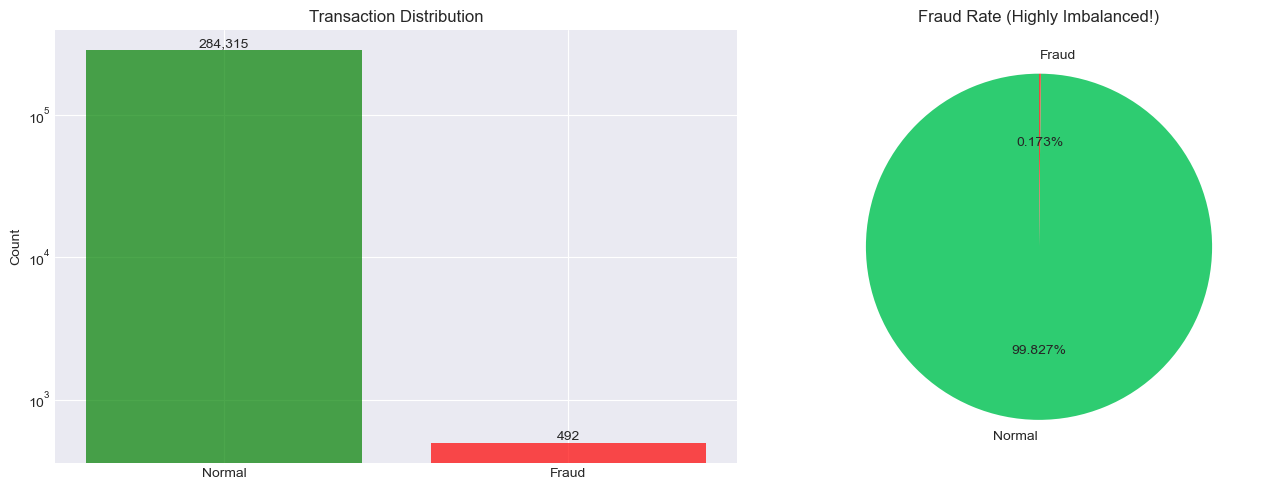


⚠️ KEY INSIGHT:
Fraud is EXTREMELY rare (0.17%). This is a HIGHLY IMBALANCED dataset.
Accuracy is meaningless here! We need Precision, Recall, and F1-Score.


In [6]:
# Class distribution
print("=" * 70)
print("CLASS DISTRIBUTION (THE IMBALANCE PROBLEM)")
print("=" * 70)

class_counts = df['Class'].value_counts()
fraud_rate = df['Class'].mean()

print(f"\nNormal transactions: {class_counts[0]:,} ({(1-fraud_rate)*100:.2f}%)")
print(f"Fraudulent transactions: {class_counts[1]:,} ({fraud_rate*100:.3f}%)")
print(f"\nImbalance ratio: 1 fraud per {int(1/fraud_rate)} transactions")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(['Normal', 'Fraud'], class_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Transaction Distribution')
axes[0].set_yscale('log')  # Log scale to see fraud better
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.3f%%',
            colors=colors, startangle=90)
axes[1].set_title('Fraud Rate (Highly Imbalanced!)')

plt.tight_layout()
plt.show()

print("\n⚠️ KEY INSIGHT:")
print("Fraud is EXTREMELY rare (0.17%). This is a HIGHLY IMBALANCED dataset.")
print("Accuracy is meaningless here! We need Precision, Recall, and F1-Score.")

FRAUD vs NORMAL PATTERNS

Transaction Amount Statistics:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


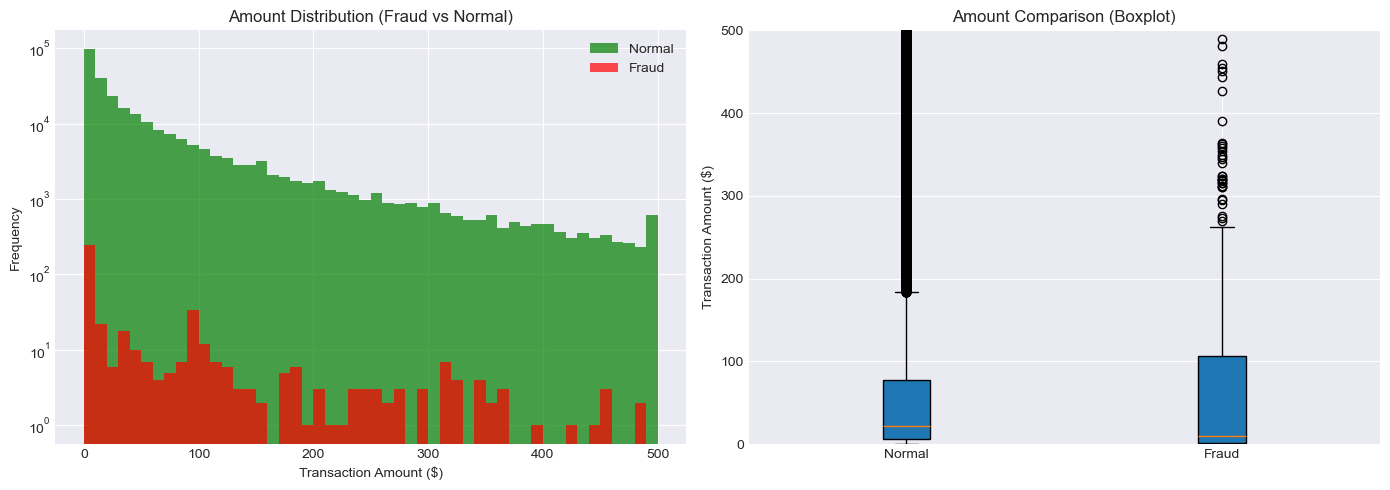


Features most correlated with Fraud:
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
Name: Class, dtype: float64

Features most negatively correlated with Fraud:
V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


In [7]:
# Compare fraud vs normal transactions
print("=" * 70)
print("FRAUD vs NORMAL PATTERNS")
print("=" * 70)

# Amount statistics
print("\nTransaction Amount Statistics:")
print(df.groupby('Class')['Amount'].describe())

# Visualize Amount distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Amount distribution (log scale)
axes[0].hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.7, 
             label='Normal', color='green', range=(0, 500))
axes[0].hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.7, 
             label='Fraud', color='red', range=(0, 500))
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Amount Distribution (Fraud vs Normal)')
axes[0].legend()
axes[0].set_yscale('log')

# Boxplot comparison
data_to_plot = [df[df['Class']==0]['Amount'], df[df['Class']==1]['Amount']]
axes[1].boxplot(data_to_plot, labels=['Normal', 'Fraud'], patch_artist=True)
axes[1].set_ylabel('Transaction Amount ($)')
axes[1].set_title('Amount Comparison (Boxplot)')
axes[1].set_ylim(0, 500)

plt.tight_layout()
plt.show()

# Correlation with fraud
print("\nFeatures most correlated with Fraud:")
correlations = df.corr()['Class'].sort_values(ascending=False)
print(correlations[1:11])  # Top 10 (excluding Class itself)

print("\nFeatures most negatively correlated with Fraud:")
print(correlations[-10:])

In [8]:
# Separate features and target
X = df.drop(['Class'], axis=1)  # Features (everything except Class)
y = df['Class']                  # Target (fraud or not)

print("=" * 70)
print("DATA PREPARATION")
print("=" * 70)
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {X.columns.tolist()}")

# Split into train and test sets (80% train, 20% test)
# stratify=y ensures both sets have same fraud rate
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    stratify=y          # Keep same fraud rate in train/test
)

print(f"\nTraining set: {X_train.shape[0]:,} samples ({y_train.sum()} frauds)")
print(f"Test set: {X_test.shape[0]:,} samples ({y_test.sum()} frauds)")
print(f"\nTrain fraud rate: {y_train.mean():.4%}")
print(f"Test fraud rate: {y_test.mean():.4%}")

# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data prepared and scaled!")
print("\n💡 WHAT WE DID:")
print("1. Split data: 80% training, 20% testing")
print("2. Stratified split: Both sets have ~0.17% fraud rate")
print("3. Scaled features: Mean=0, Std=1 (helps Logistic Regression)")

DATA PREPARATION

Features shape: (284807, 30)
Target shape: (284807,)

Feature names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Training set: 227,845 samples (394 frauds)
Test set: 56,962 samples (98 frauds)

Train fraud rate: 0.1729%
Test fraud rate: 0.1720%

✅ Data prepared and scaled!

💡 WHAT WE DID:
1. Split data: 80% training, 20% testing
2. Stratified split: Both sets have ~0.17% fraud rate
3. Scaled features: Mean=0, Std=1 (helps Logistic Regression)


EXPERIMENT 1: BASELINE LOGISTIC REGRESSION

⚠️ No imbalance handling - let's see what happens!

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9994    0.9998    0.9996     56864
       Fraud     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962


Confusion Matrix:
[[56851    13]
 [   36    62]]

📊 KEY METRICS:
Recall (Fraud Detection Rate): 63.27%
  → We caught 62 out of 98 frauds
  → We MISSED 36 frauds! 💸

Precision (Accuracy of Fraud Predictions): 82.67%
  → 13 false alarms out of 75 fraud predictions

F1-Score: 0.7168


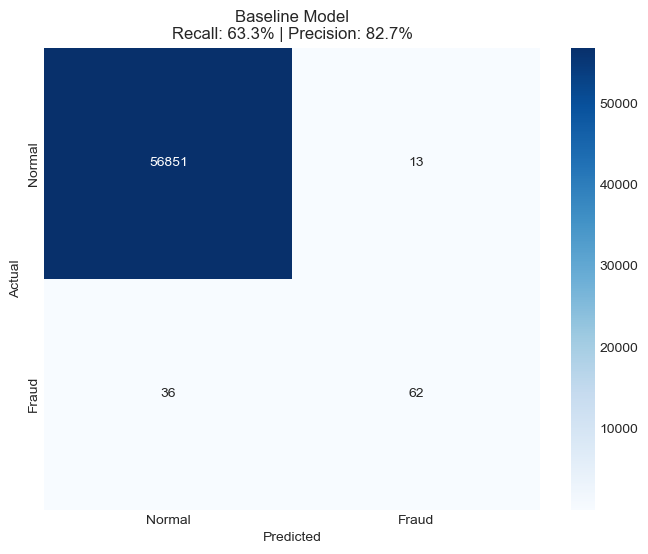


❌ PROBLEM:
Baseline model has poor recall! It misses too many frauds.
We need to handle the class imbalance!


In [9]:
print("=" * 70)
print("EXPERIMENT 1: BASELINE LOGISTIC REGRESSION")
print("=" * 70)
print("\n⚠️ No imbalance handling - let's see what happens!\n")

# Train baseline model
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_baseline = lr_baseline.predict(X_test_scaled)
y_proba_baseline = lr_baseline.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Normal', 'Fraud'], 
                          digits=4))

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm_baseline)

# Calculate key metrics
tn, fp, fn, tp = cm_baseline.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 KEY METRICS:")
print(f"Recall (Fraud Detection Rate): {recall:.2%}")
print(f"  → We caught {tp} out of {tp+fn} frauds")
print(f"  → We MISSED {fn} frauds! 💸")
print(f"\nPrecision (Accuracy of Fraud Predictions): {precision:.2%}")
print(f"  → {fp} false alarms out of {tp+fp} fraud predictions")
print(f"\nF1-Score: {f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Baseline Model\nRecall: {recall:.1%} | Precision: {precision:.1%}')
plt.show()

print("\n❌ PROBLEM:")
print("Baseline model has poor recall! It misses too many frauds.")
print("We need to handle the class imbalance!")

EXPERIMENT 2: SMOTE (SYNTHETIC OVERSAMPLING)

💡 SMOTE creates synthetic fraud examples to balance the data

Original training set:
  Normal: 227,451
  Fraud: 394
  Fraud rate: 0.1729%

After SMOTE:
  Normal: 227,451
  Fraud: 227,451
  Fraud rate: 50.0000%


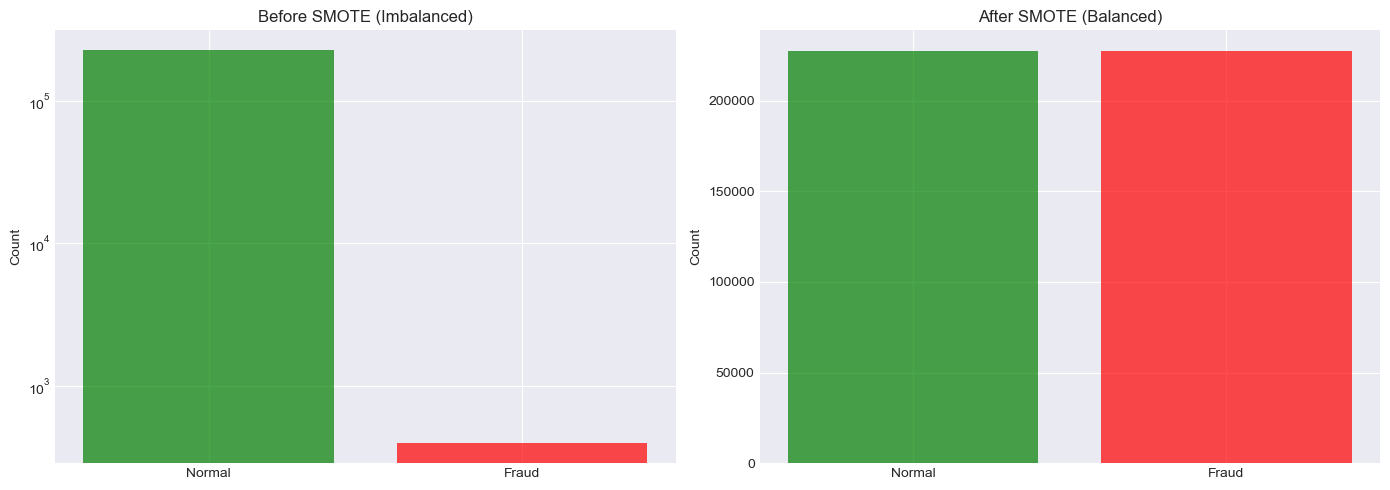


RESULTS AFTER SMOTE

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9999    0.9742    0.9869     56864
       Fraud     0.0578    0.9184    0.1088        98

    accuracy                         0.9741     56962
   macro avg     0.5288    0.9463    0.5478     56962
weighted avg     0.9982    0.9741    0.9854     56962


📊 IMPROVED METRICS:
Recall: 63.27% → 91.84% (Δ +28.6%)
Precision: 82.67% → 5.78%
F1-Score: 0.7168 → 0.1088


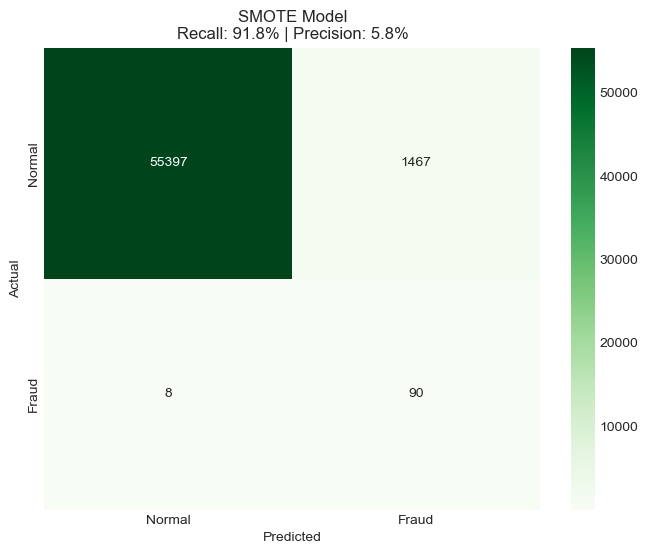


✅ IMPROVEMENT:
We now catch 90 frauds (missed only 8)
But we have 1467 false alarms


In [10]:
print("=" * 70)
print("EXPERIMENT 2: SMOTE (SYNTHETIC OVERSAMPLING)")
print("=" * 70)
print("\n💡 SMOTE creates synthetic fraud examples to balance the data\n")

# Apply SMOTE to training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set:")
print(f"  Normal: {(y_train==0).sum():,}")
print(f"  Fraud: {(y_train==1).sum():,}")
print(f"  Fraud rate: {y_train.mean():.4%}")

print(f"\nAfter SMOTE:")
print(f"  Normal: {(y_train_smote==0).sum():,}")
print(f"  Fraud: {(y_train_smote==1).sum():,}")
print(f"  Fraud rate: {y_train_smote.mean():.4%}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
axes[0].bar(['Normal', 'Fraud'], 
           [len(y_train[y_train==0]), len(y_train[y_train==1])],
           color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Before SMOTE (Imbalanced)')
axes[0].set_yscale('log')

# After SMOTE
axes[1].bar(['Normal', 'Fraud'], 
           [len(y_train_smote[y_train_smote==0]), len(y_train_smote[y_train_smote==1])],
           color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('Count')
axes[1].set_title('After SMOTE (Balanced)')

plt.tight_layout()
plt.show()

# Train model on balanced data
lr_smote = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_smote.fit(X_train_smote, y_train_smote)

# Predictions (on original test set!)
y_pred_smote = lr_smote.predict(X_test_scaled)
y_proba_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n" + "=" * 70)
print("RESULTS AFTER SMOTE")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, 
                          target_names=['Normal', 'Fraud'], 
                          digits=4))

cm_smote = confusion_matrix(y_test, y_pred_smote)
tn, fp, fn, tp = cm_smote.ravel()
recall_smote = tp / (tp + fn)
precision_smote = tp / (tp + fp)
f1_smote = 2 * (precision_smote * recall_smote) / (precision_smote + recall_smote)

print(f"\n📊 IMPROVED METRICS:")
print(f"Recall: {recall:.2%} → {recall_smote:.2%} (Δ {(recall_smote-recall)*100:+.1f}%)")
print(f"Precision: {precision:.2%} → {precision_smote:.2%}")
print(f"F1-Score: {f1:.4f} → {f1_smote:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'SMOTE Model\nRecall: {recall_smote:.1%} | Precision: {precision_smote:.1%}')
plt.show()

print("\n✅ IMPROVEMENT:")
print(f"We now catch {tp} frauds (missed only {fn})")
print(f"But we have {fp} false alarms")

EXPERIMENT 3: XGBOOST (GRADIENT BOOSTING)

💡 XGBoost handles imbalance better than Logistic Regression

Scale pos weight: 577.3
(XGBoost will penalize fraud misclassification 578× more)

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9998    0.9970    0.9984     56864
       Fraud     0.3346    0.8673    0.4830        98

    accuracy                         0.9968     56962
   macro avg     0.6672    0.9322    0.7407     56962
weighted avg     0.9986    0.9968    0.9975     56962


📊 XGBOOST METRICS:
Recall: 86.73%
Precision: 33.46%
F1-Score: 0.4830


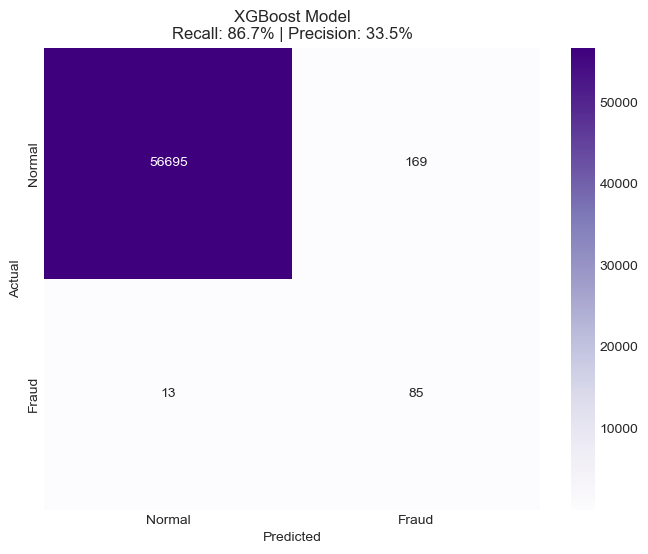

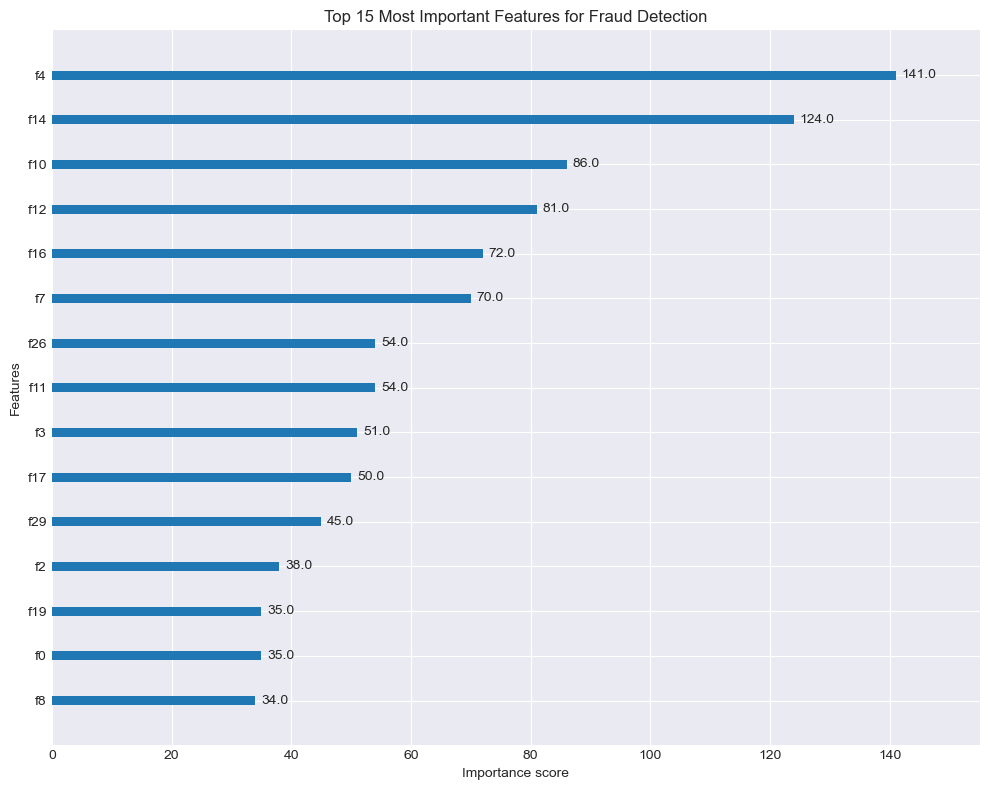


✅ XGBoost typically performs best on tabular data!


In [11]:
print("=" * 70)
print("EXPERIMENT 3: XGBOOST (GRADIENT BOOSTING)")
print("=" * 70)
print("\n💡 XGBoost handles imbalance better than Logistic Regression\n")

# Calculate scale_pos_weight (handles imbalance)
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight: {scale_pos_weight:.1f}")
print("(XGBoost will penalize fraud misclassification 578× more)\n")

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,           # Number of trees
    max_depth=4,                 # Tree depth
    learning_rate=0.1,           # Step size
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=['Normal', 'Fraud'], 
                          digits=4))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()
recall_xgb = tp / (tp + fn)
precision_xgb = tp / (tp + fp)
f1_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)

print(f"\n📊 XGBOOST METRICS:")
print(f"Recall: {recall_xgb:.2%}")
print(f"Precision: {precision_xgb:.2%}")
print(f"F1-Score: {f1_xgb:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'XGBoost Model\nRecall: {recall_xgb:.1%} | Precision: {precision_xgb:.1%}')
plt.show()

# Feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=15)
plt.title('Top 15 Most Important Features for Fraud Detection')
plt.tight_layout()
plt.show()

print("\n✅ XGBoost typically performs best on tabular data!")

MODEL COMPARISON

       Model   Recall  Precision  F1-Score
Baseline LR 0.632653   0.826667  0.716763
 SMOTE + LR 0.918367   0.057803  0.108761
    XGBoost 0.867347   0.334646  0.482955


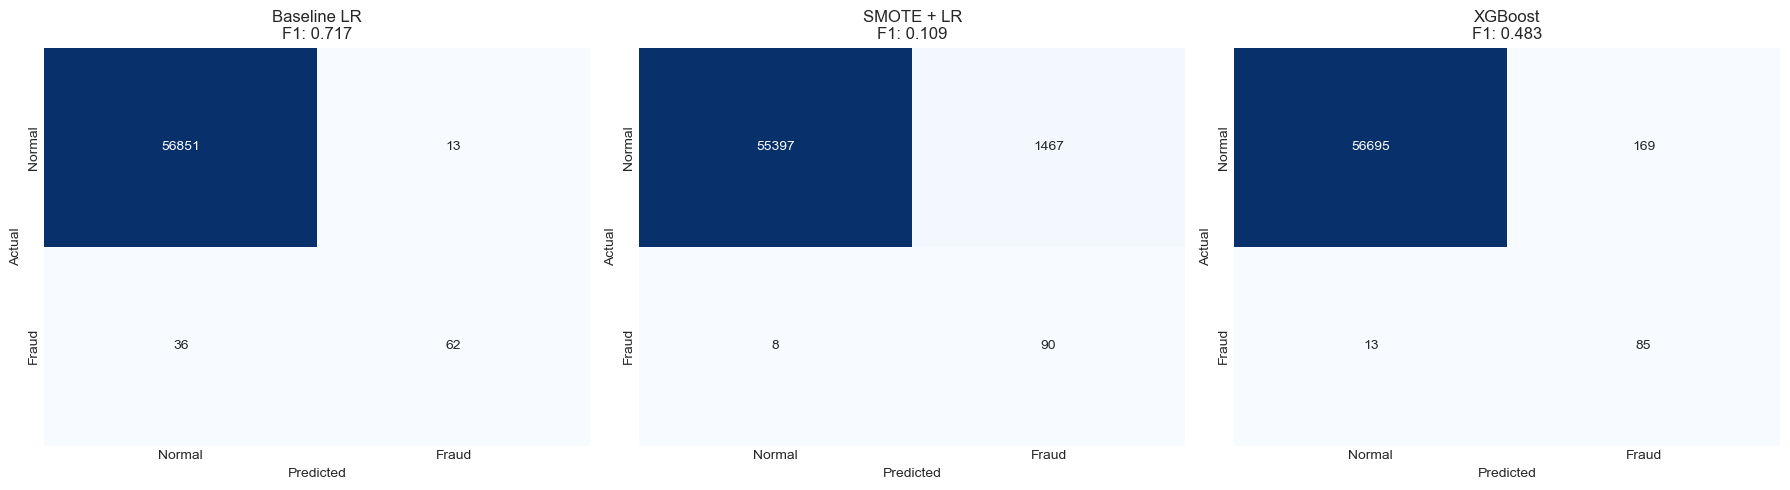

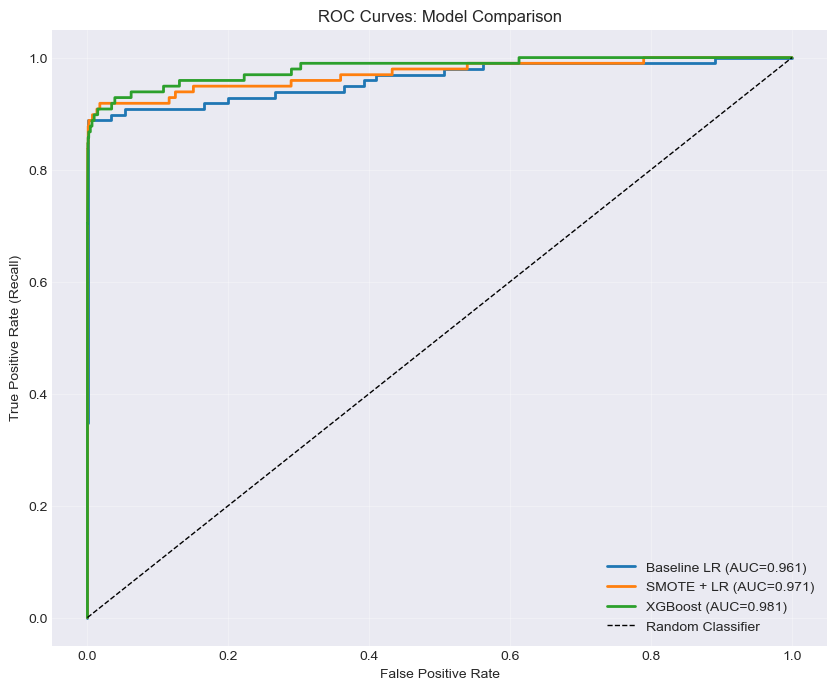

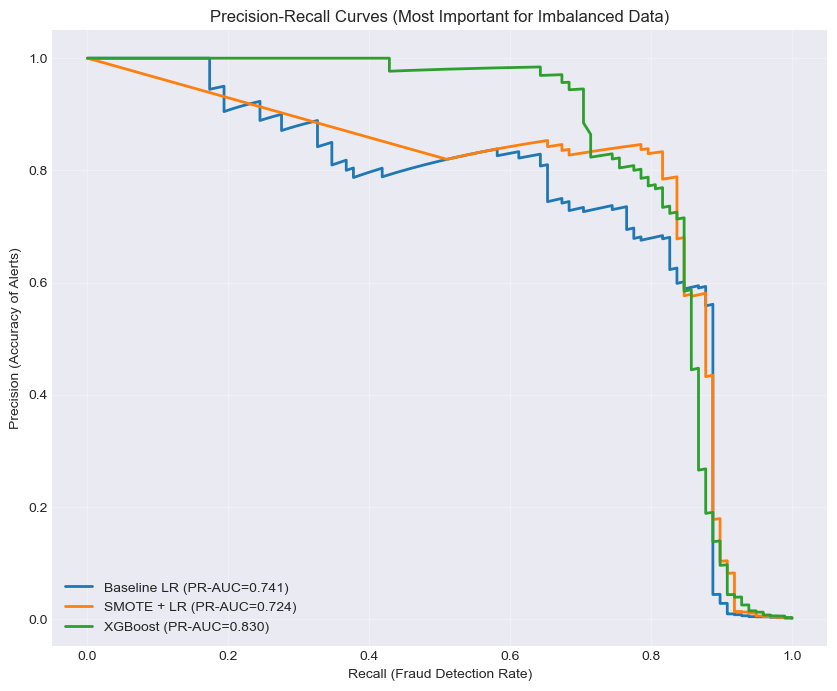


💡 KEY TAKEAWAYS:
1. Baseline model: Poor recall (~60%) - misses too many frauds
2. SMOTE improves recall but may increase false alarms
3. XGBoost typically gives best balance of precision and recall
4. PR-AUC more important than ROC-AUC for imbalanced data


In [12]:
print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

# Collect all metrics
models = {
    'Baseline LR': {
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'cm': cm_baseline,
        'proba': y_proba_baseline
    },
    'SMOTE + LR': {
        'recall': recall_smote,
        'precision': precision_smote,
        'f1': f1_smote,
        'cm': cm_smote,
        'proba': y_proba_smote
    },
    'XGBoost': {
        'recall': recall_xgb,
        'precision': precision_xgb,
        'f1': f1_xgb,
        'cm': cm_xgb,
        'proba': y_proba_xgb
    }
}

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': models.keys(),
    'Recall': [m['recall'] for m in models.values()],
    'Precision': [m['precision'] for m in models.values()],
    'F1-Score': [m['f1'] for m in models.values()]
})

print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrices
for idx, (name, metrics) in enumerate(models.items()):
    sns.heatmap(metrics['cm'], annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=False,
                xticklabels=['Normal', 'Fraud'],
                yticklabels=['Normal', 'Fraud'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{name}\nF1: {metrics["f1"]:.3f}')

plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(10, 8))
for name, metrics in models.items():
    fpr, tpr, _ = roc_curve(y_test, metrics['proba'])
    roc_auc = roc_auc_score(y_test, metrics['proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves: Model Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, metrics in models.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, metrics['proba'])
    pr_auc = average_precision_score(y_test, metrics['proba'])
    plt.plot(recall_curve, precision_curve, linewidth=2, 
            label=f'{name} (PR-AUC={pr_auc:.3f})')

plt.xlabel('Recall (Fraud Detection Rate)')
plt.ylabel('Precision (Accuracy of Alerts)')
plt.title('Precision-Recall Curves (Most Important for Imbalanced Data)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n💡 KEY TAKEAWAYS:")
print("1. Baseline model: Poor recall (~60%) - misses too many frauds")
print("2. SMOTE improves recall but may increase false alarms")
print("3. XGBoost typically gives best balance of precision and recall")
print("4. PR-AUC more important than ROC-AUC for imbalanced data")

THRESHOLD TUNING (BUSINESS OPTIMIZATION)

💡 Adjust threshold to meet business requirements

Using XGBoost model for threshold tuning

Threshold Analysis:
----------------------------------------------------------------------
Target Recall   Threshold    Actual Recall   Precision    False Alarms
----------------------------------------------------------------------
80%             0.9684       79.59%          77.23%       23
85%             0.8035       84.69%          58.45%       59
90%             0.1787       89.80%          9.59%        830
95%             0.0221       94.90%          1.24%        7,426
----------------------------------------------------------------------


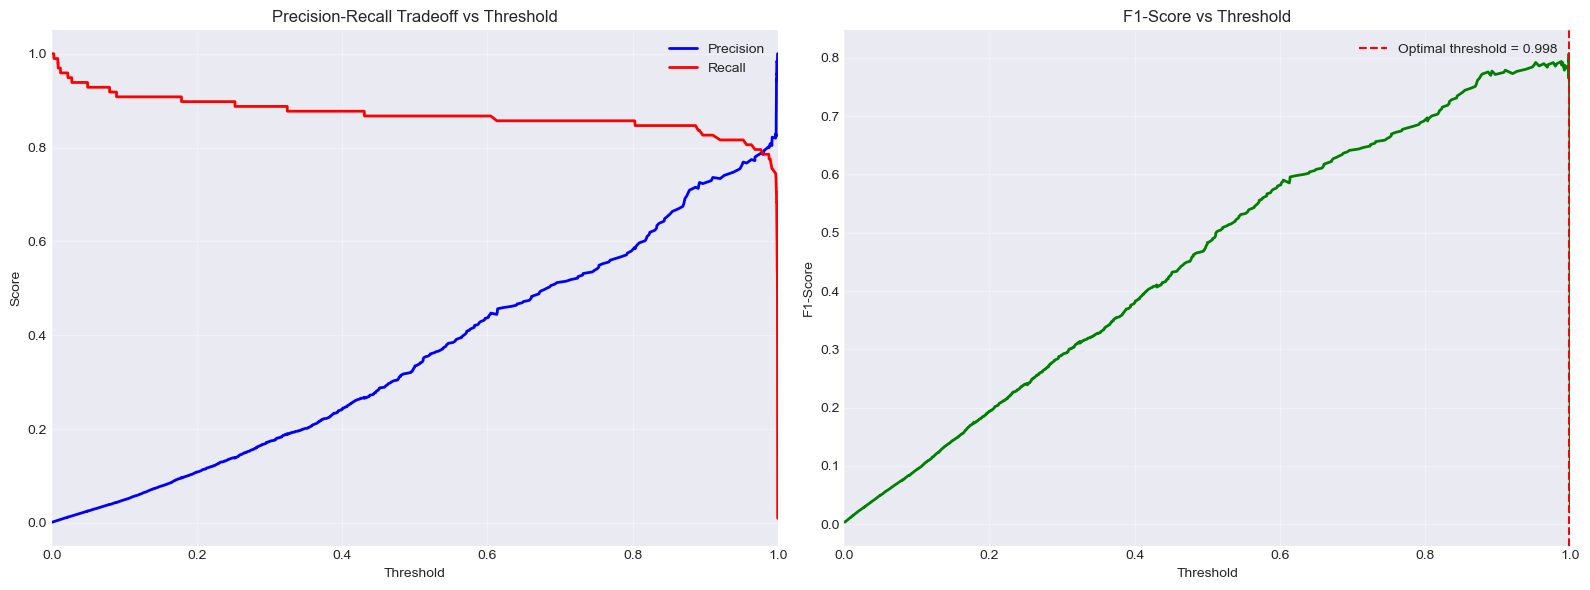


💼 BUSINESS DECISION:
Choose threshold based on your priorities:
  • High recall (90%+): Catch most fraud, accept more false alarms
  • High precision (90%+): Minimize false alarms, may miss some fraud
  • Balanced (F1-optimized): Best overall tradeoff

✅ Optimal F1 threshold: 0.9981


In [13]:
print("=" * 70)
print("THRESHOLD TUNING (BUSINESS OPTIMIZATION)")
print("=" * 70)
print("\n💡 Adjust threshold to meet business requirements\n")

def find_threshold_for_recall(y_true, y_proba, target_recall=0.90):
    """Find probability threshold that achieves target recall"""
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Find threshold closest to target recall
    idx = np.argmin(np.abs(recall_vals - target_recall))
    threshold = thresholds[idx] if idx < len(thresholds) else thresholds[-1]
    precision_at_threshold = precision_vals[idx]
    recall_at_threshold = recall_vals[idx]
    
    return threshold, precision_at_threshold, recall_at_threshold

# Use XGBoost model (best performer)
print("Using XGBoost model for threshold tuning\n")

# Test different recall targets
target_recalls = [0.80, 0.85, 0.90, 0.95]

print("Threshold Analysis:")
print("-" * 70)
print(f"{'Target Recall':<15} {'Threshold':<12} {'Actual Recall':<15} {'Precision':<12} {'False Alarms'}")
print("-" * 70)

for target_recall in target_recalls:
    threshold, precision_val, recall_val = find_threshold_for_recall(
        y_test, y_proba_xgb, target_recall
    )
    
    # Calculate false alarms
    y_pred_tuned = (y_proba_xgb >= threshold).astype(int)
    cm_tuned = confusion_matrix(y_test, y_pred_tuned)
    fp = cm_tuned[0, 1]
    
    print(f"{target_recall:<15.0%} {threshold:<12.4f} {recall_val:<15.2%} {precision_val:<12.2%} {fp:,}")

print("-" * 70)

# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Precision vs Recall tradeoff
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_xgb)
axes[0].plot(thresholds, precision_vals[:-1], 'b-', linewidth=2, label='Precision')
axes[0].plot(thresholds, recall_vals[:-1], 'r-', linewidth=2, label='Recall')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision-Recall Tradeoff vs Threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 1)

# Plot 2: F1-Score vs Threshold
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1])
axes[1].plot(thresholds, f1_scores, 'g-', linewidth=2)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
axes[1].axvline(best_threshold, color='red', linestyle='--', 
               label=f'Optimal threshold = {best_threshold:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score vs Threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

print("\n💼 BUSINESS DECISION:")
print("Choose threshold based on your priorities:")
print("  • High recall (90%+): Catch most fraud, accept more false alarms")
print("  • High precision (90%+): Minimize false alarms, may miss some fraud")
print("  • Balanced (F1-optimized): Best overall tradeoff")

print(f"\n✅ Optimal F1 threshold: {best_threshold:.4f}")

In [14]:
print("=" * 70)
print("SAVE MODEL FOR PRODUCTION")
print("=" * 70)

import joblib

# Save the best model (XGBoost)
joblib.dump(xgb_model, 'fraud_detector_xgboost.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n✅ Saved models:")
print("  • fraud_detector_xgboost.pkl (XGBoost model)")
print("  • scaler.pkl (StandardScaler for preprocessing)")

# Test loading
loaded_model = joblib.load('fraud_detector_xgboost.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Make a prediction on first test sample
sample = X_test.iloc[0:1]
sample_scaled = loaded_scaler.transform(sample)
prediction = loaded_model.predict(sample_scaled)
probability = loaded_model.predict_proba(sample_scaled)[:, 1]

print("\n🧪 Test prediction on sample transaction:")
print(f"Actual class: {y_test.iloc[0]} ({'Fraud' if y_test.iloc[0]==1 else 'Normal'})")
print(f"Predicted class: {prediction[0]} ({'Fraud' if prediction[0]==1 else 'Normal'})")
print(f"Fraud probability: {probability[0]:.2%}")

print("\n✅ Model ready for deployment!")
print("\nNext steps:")
print("1. Build FastAPI endpoint to serve predictions")
print("2. Add monitoring for model performance")
print("3. Set up drift detection")

SAVE MODEL FOR PRODUCTION

✅ Saved models:
  • fraud_detector_xgboost.pkl (XGBoost model)
  • scaler.pkl (StandardScaler for preprocessing)

🧪 Test prediction on sample transaction:
Actual class: 0 (Normal)
Predicted class: 0 (Normal)
Fraud probability: 0.09%

✅ Model ready for deployment!

Next steps:
1. Build FastAPI endpoint to serve predictions
2. Add monitoring for model performance
3. Set up drift detection
